# GENERAL OVERVIEW
The images after loading were resized to 250 size and randomly cropped to 224, and further augmentations were applied to the image.

The model used was ResNext 101-32x8d, which was provided pretrained by pytorch.

I trained the model two times one using 0.8-0.2 split and 0.95-0.05 and ensembled both the models.

For making predictions, I used extensive test time augmentations like flips, rotation and crops. the final predictions were found by averaging all the predictions.

In [ ]:
!nvidia-smi

Mon Sep 14 10:47:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# THE DATASET GIVEN IS STORED IN MY DRIVE.
# to check the authenticity of the dataset, the data folder being imported can by found at
# https://drive.google.com/file/d/19WwPSZuEDDwpBTn-e3LSabCsZ4mgc9N2/view?usp=sharing

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def get_file_from_drive(folder_id, file_name):
    file_list = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
    for file in file_list:
            if file['title'] == file_name:
                return file['id']


drive_folder_id = '1oj3k3kGIpqaYfCZpJ2aqV5f3yWzQFeVC'

filenames = ['cifar_dataset.zip']

def upload_data_system():

    for file in filenames:
        downloaded = drive.CreateFile({'id': get_file_from_drive(drive_folder_id, file)})
        downloaded.GetContentFile(file) 


upload_data_system()

In [ ]:
!unzip -q cifar_dataset 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils
from PIL import Image
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import time
import os
import copy
import tqdm


In [ ]:
# The dataset class for loading the dataset
class Cifar10dataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, class_names, transform=None):

        self.transform = transform
        self.class_names = class_names

        self.X = []
        self.Y = []
        i = 0
        for class_ in class_names:
            class_dir = os.path.join(data_dir, class_)
            images = os.listdir(class_dir)
            for image in tqdm.tqdm(images):
                image_path = os.path.join(class_dir, image)
                pil_img = Image.open(image_path)
                self.X.append(Image.open(image_path))
                self.Y.append(int(class_names.index(class_)))
                i += 1


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # if index is tensor convert it to list
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'image': self.X[idx], 'label': self.Y[idx]}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

    # will be used to get training and testing splits of the dataset
    def getXY(self):
        return self.X, self.Y


In [ ]:
# MAKING THE DATASET
# this will be used everywhere where, length, index or classes will be referred
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cif_dataset = Cifar10dataset(data_dir='CIFAR10/train',
                             class_names=class_names)

100%|██████████| 5000/5000 [00:00<00:00, 8853.07it/s]


0 (32, 32) airplane


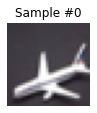

1 (32, 32) airplane


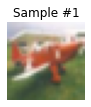

2 (32, 32) airplane


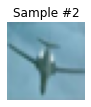

3 (32, 32) airplane


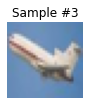

In [ ]:
# GETTING SOME SAMPLES
fig = plt.figure()

for i in range(len(cif_dataset)):
    sample = cif_dataset[i]

    print(i, sample['image'].size, class_names[int(sample['label'])])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    plt.show()

    if i == 3:
        plt.show()
        break

In [ ]:
# DATA TRANSFORMS (DATA AUGMENTATIONS)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((250, 250), interpolation = 1),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.3), transforms.ColorJitter(contrast=(0.8,1.1))]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.4, scale=(0.02,0.09))
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224), interpolation = 1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# splitting of the dataset, here the split ratio is 0.005 which is used for one model, other model used 0.2 as the split ratio
from sklearn.model_selection import train_test_split
X, Y = cif_dataset.getXY()
indices = [x for x in range(50000)]
xtrain, xval, ytrain, yval, train_idx, valid_idx = train_test_split(X, Y, indices,test_size=0.005, stratify=Y, 
                                                                    shuffle=True,
                                                                    random_state=0)
len(xtrain), len(xval)

(49750, 250)

In [ ]:
# SUBSET OF DATASET
train_dataset = torch.utils.data.Subset(cif_dataset, train_idx)
val_dataset = torch.utils.data.Subset(cif_dataset, valid_idx)

In [ ]:
# MAPPING THE TRANSFORMS ON THE SPLITS
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index]['image']) 
        else:     
            x = self.dataset[index]['image']  # image
        y = self.dataset[index]['label']   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)



In [ ]:
# CREATING THE TRAINING AND VALIDATION LOADER
BATCH_SIZE = 32
NUM_WORKERS = 4

tng_data_tf = MapDataset(train_dataset, data_transforms['train'])
train_loader = torch.utils.data.DataLoader(tng_data_tf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

val_data_tf = MapDataset(val_dataset, data_transforms['val'])
val_loader = torch.utils.data.DataLoader(val_data_tf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

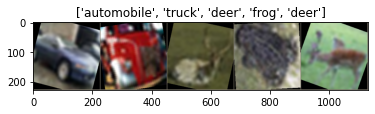

In [ ]:
# CHECKING IF DATALOADER WORKS
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

inputs = inputs[:5]
classes = classes[:5]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# using device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# dataloaders
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

# dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [ ]:
# function to shuffle a minibatch
def shuffle_minibatch(x, y):
    assert x.size(0)== y.size(0)
    indices = torch.randperm(x.size(0))
    return x[indices], y[indices]

In [ ]:
num_batches = dataset_sizes['train']//BATCH_SIZE
print_every = num_batches//8



# TRAINING FUNCTION LOOP


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    try:
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0


        phase = 'val'
        for epoch in range(num_epochs):

            if phase == 'val':
                print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
                print('-' * 10)
            time.sleep(1)
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                data_loader = dataloaders[phase]

                # storing time at start of epoch
                ep_time = time.time()

                # EPOCH ITERATION
                for i,(inputs, labels) in enumerate(data_loader):
                    bat_start = time.time()
                    inputs = inputs.to(device)
                    labels = labels.to(device)



                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)

                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    if phase == 'train':
                        if (i+1)%print_every == 0:
                            print("\t Batch {}/{} ===> Train Loss {:.4f} and Accuracy {:.4f} at {:.1f} s after start of epoch".format(i+1,num_batches,
                                                                                    running_loss / (BATCH_SIZE*(i+1)),
                                                                                    running_corrects.double() / (BATCH_SIZE*(i+1)),
                                                                                    time.time()-ep_time ))

                # END OF EPOCH ITERATION

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('\n{} Loss: {:.4f} Acc: {:.4f}\n'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model

    except KeyboardInterrupt:
        model.load_state_dict(best_model_wts)
        return model


In [ ]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [ ]:
# PRETRAINED MODEL ===>  I AM USING RESNEXT 101_32X8d PRETRAINED ON IMAGENET
model_ft = models.resnext101_32x8d(pretrained=True)

In [ ]:
# Unfreeze model weights
for param in model_ft.parameters():
    param.requires_grad = True

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
import torch.nn.functional as F
# ADDING MY HEAD
class My_Module(nn.Module):

    def __init__(self, in_features, num_classes):
        super(My_Module, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.Dropout(0.15)(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

last_ftrs = model_ft.fc.in_features
my_module = My_Module(last_ftrs, len(class_names))
my_module

My_Module(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
# adding my head
model_ft.fc = nn.Sequential(my_module)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9, nesterov=True)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)


In [ ]:
model_ft = model_ft.to(device)

In [ ]:
# check gpu usage :')
!nvidia-smi

Mon Sep 14 10:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   1145MiB / 16280MiB |     22%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# DUE TO COLAB RUNTIME TIME LIMITS, I HAD TO TRAIN THE MODEL FOR SOME EPOCHS AND THEN STORE IT IN THE DRIVE, AND THEN LOAD AND TRAIN AGAIN.
#LOADING THE MODEL
model_save_name = 'full_trained.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model_ft.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
# training the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50) # max val acc till now = 0.9880


Epoch 1/50
----------
	 Batch 194/1554 ===> Train Loss 0.0272 and Accuracy 0.9915 at 169.2 s after start of epoch
	 Batch 388/1554 ===> Train Loss 0.0289 and Accuracy 0.9909 at 337.6 s after start of epoch
	 Batch 582/1554 ===> Train Loss 0.0286 and Accuracy 0.9911 at 506.3 s after start of epoch
	 Batch 776/1554 ===> Train Loss 0.0284 and Accuracy 0.9909 at 674.9 s after start of epoch
	 Batch 970/1554 ===> Train Loss 0.0281 and Accuracy 0.9909 at 843.8 s after start of epoch
	 Batch 1164/1554 ===> Train Loss 0.0279 and Accuracy 0.9910 at 1012.5 s after start of epoch
	 Batch 1358/1554 ===> Train Loss 0.0274 and Accuracy 0.9911 at 1181.4 s after start of epoch
	 Batch 1552/1554 ===> Train Loss 0.0269 and Accuracy 0.9914 at 1350.5 s after start of epoch

train Loss: 0.0269 Acc: 0.9915


val Loss: 0.0598 Acc: 0.9880



Epoch 2/50
----------
	 Batch 194/1554 ===> Train Loss 0.0231 and Accuracy 0.9929 at 169.2 s after start of epoch
	 Batch 388/1554 ===> Train Loss 0.0265 and Accuracy 0.

In [ ]:
# SOMETIMES THE MODEL HAS TO BE SAVED/LOADED in the drive DUE TO WORKING TIME ISSUES.
# SAVING THE MODEL
"""model_save_name = '[takethisout]full_trained.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model_ft.state_dict(), path)"""

In [ ]:
!nvidia-smi

Thu Aug 27 12:20:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |   1239MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model_ft.eval()
read_img = Image.open(f'CIFAR10/test/02346_test.png')
with torch.no_grad():
    read_img = read_img.resize((224,224))
    img_tensor = transforms.ToTensor()(read_img)
    img_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_tensor)
    img_tensor = img_tensor.unsqueeze_(0)
    img_tensor = img_tensor.to(device)
    outputs = model_ft(img_tensor)
outputs

tensor([[-2.7055, -1.4137, -0.9259,  0.5115, 11.8014,  2.7942, -1.5204, -0.5183,
         -3.7345, -3.3094]], device='cuda:0')

In [ ]:
#######       SHOWING PREDICTIONS IN A HORIZONTAL BAR PLOT FORMAT  (PYTORCH)      #########

# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.5 

def show_preds(logits, image, correct_label=None, class_list=None):

  if len(logits.shape) > 1:
    logits = torch.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_label is not None:
    ax1.set_title(class_names[correct_label])
  classes = []
  scores = []
  logits_max = torch.max(logits)

  logits_max, logits = np.array(logits_max.cpu()), np.array(logits.cpu())  
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if class_list is not None:
      classes.append(class_names[j])
    
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

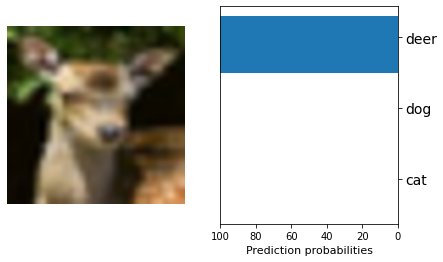

In [ ]:
show_preds(outputs, read_img, class_list=class_names)

In [ ]:
# The old predictions were stored in the runtime
old1 = np.load('fin_9830.npy')

In [ ]:
# to make predictions, I used Test time augmentations.
# i used flip, rotate, left 75% crop and right 75% crop.
# THESE ARE THE TEST TIME AUGMENTATIONS I USED.
# THEY ARE COMMENTED OUT BECAUSE OF MY VARIOUS EXPERIMENTS OF WHAT WORKS AND WHAT DOES NOT.

import pandas as pd
import PIL
from tqdm.notebook import tqdm
# helper for images
def preprocess_image(image):

    with torch.no_grad():
        image = image.resize((224,224), resample=PIL.Image.LANCZOS)
        img_tensor = transforms.ToTensor()(image)
        img_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_tensor)
        img_tensor = img_tensor.unsqueeze_(0)
        img_tensor = img_tensor.to(device)
    return img_tensor

output = pd.DataFrame(columns=['filename', 'label'])
images_list = sorted(os.listdir('CIFAR10/test/'))
old_preds_tense1 = torch.Tensor(old1).to(device)
#old_preds_tense2 = torch.Tensor(old2).to(device)
output_ar = np.zeros((10000, 10))

model_ft.eval()

i = 0
for image in tqdm(images_list):
    image = images_list[i]
    output.loc[i,'filename'] = image

    read_img = Image.open(f'CIFAR10/test/{image}')
    #read_img_flipped = read_img.transpose(Image.FLIP_LEFT_RIGHT)

    #left_crop = read_img.crop((0, 0, 168, 224))
    #right_crop = read_img.crop((56, 0, 224, 224))

    #read_img_lcrop = left_crop.resize((224,224), resample=PIL.Image.LANCZOS)
    #read_img_rcrop = right_crop.resize((224,224), resample=PIL.Image.LANCZOS)

    with torch.no_grad():
        image1 = preprocess_image(read_img)
        #image2 = preprocess_image(read_img_flipped)
        #image3 = preprocess_image(read_img_lcrop)
        #image4 = preprocess_image(read_img_rcrop)

        image1 = image1.to(device)
        #image2 = image2.to(device)
        #image3 = image3.to(device)
        #image4 = image4.to(device)
 

        outputs1 = model_ft(image1)
        #outputs2 = model_ft(image2)
        #outputs3 = model_ft(image3)
        #outputs4 = model_ft(image4)


        #outputs = (outputs1 + outputs2 + outputs3 + outputs4)/4 

    outputs = (0.8)*old_preds_tense1[i, :] + (0.2)*outputs1
    output_ar[i, :] = outputs.cpu()
    class_ = class_names[int(torch.argmax(outputs))]

    output.loc[i,'label'] = class_

    i += 1

I store the value counts of my hightest predictions so that I don't repeat the submission again.

In [ ]:
output['label'].value_counts() # 98.29

cat           1016
automobile    1015
ship          1011
bird          1003
airplane      1001
frog           999
deer           998
horse          991
truck          984
dog            982
Name: label, dtype: int64

In [ ]:
output['label'].value_counts() #98.30

cat           1016
automobile    1013
ship          1012
bird          1004
airplane      1000
frog           997
deer           997
horse          992
truck          985
dog            984
Name: label, dtype: int64

In [ ]:
output['label'].value_counts() # 98.33

cat           1016
automobile    1015
ship          1011
bird          1002
airplane      1001
deer          1000
frog           999
horse          991
truck          983
dog            982
Name: label, dtype: int64

In [ ]:
output['label'].value_counts() # 98.30

automobile    1016
cat           1014
ship          1011
deer          1003
bird          1000
frog          1000
airplane       999
horse          991
dog            984
truck          982
Name: label, dtype: int64

In [ ]:
output.to_csv('pred.csv', index=False)

In [ ]:
np.save('fin_9833.npy', output_ar)